In [1]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
import networkx as nx
import matplotlib.pyplot as plt
import hierarchical as hrc
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda:1")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")
g = torch.load('matricies.pth').to(device) # 'FILE_PATH' in store_matrices.py

vocab_dict = tokenizer.get_vocab()
vocab_list = [None] * (max(vocab_dict.values()) + 1)
for word, index in vocab_dict.items():
    vocab_list[index] = word

In [3]:
with open("data/animals.json", "r", encoding="utf-8") as f:
    data = json.load(f)

categories = ['mammal', 'bird', 'reptile', 'fish', 'amphibian', 'insect']
animals_token, animals_ind, animals_g = hrc.get_animal_category(data, categories,  vocab_dict, g)

dirs = {k: hrc.estimate_cat_dir(v, g, vocab_dict) for k, v in animals_token.items()}

all_animals_tokens = [a for k, v in animals_token.items() for a in v]
dirs.update({'animal': hrc.estimate_cat_dir(all_animals_tokens, g, vocab_dict)})
animals_token.update({'animal': all_animals_tokens})

with open("data/plants.json", "r", encoding="utf-8") as f:
    data = json.load(f)

plants_token = []
vocab_set = set(vocab_dict.keys())
lemmas = data["plant"]
for w in lemmas:
    plants_token.extend(hrc.noun_to_gemma_vocab_elements(w, vocab_set))

dirs_plants = hrc.estimate_cat_dir(plants_token, g, vocab_dict)

## 2D Plots

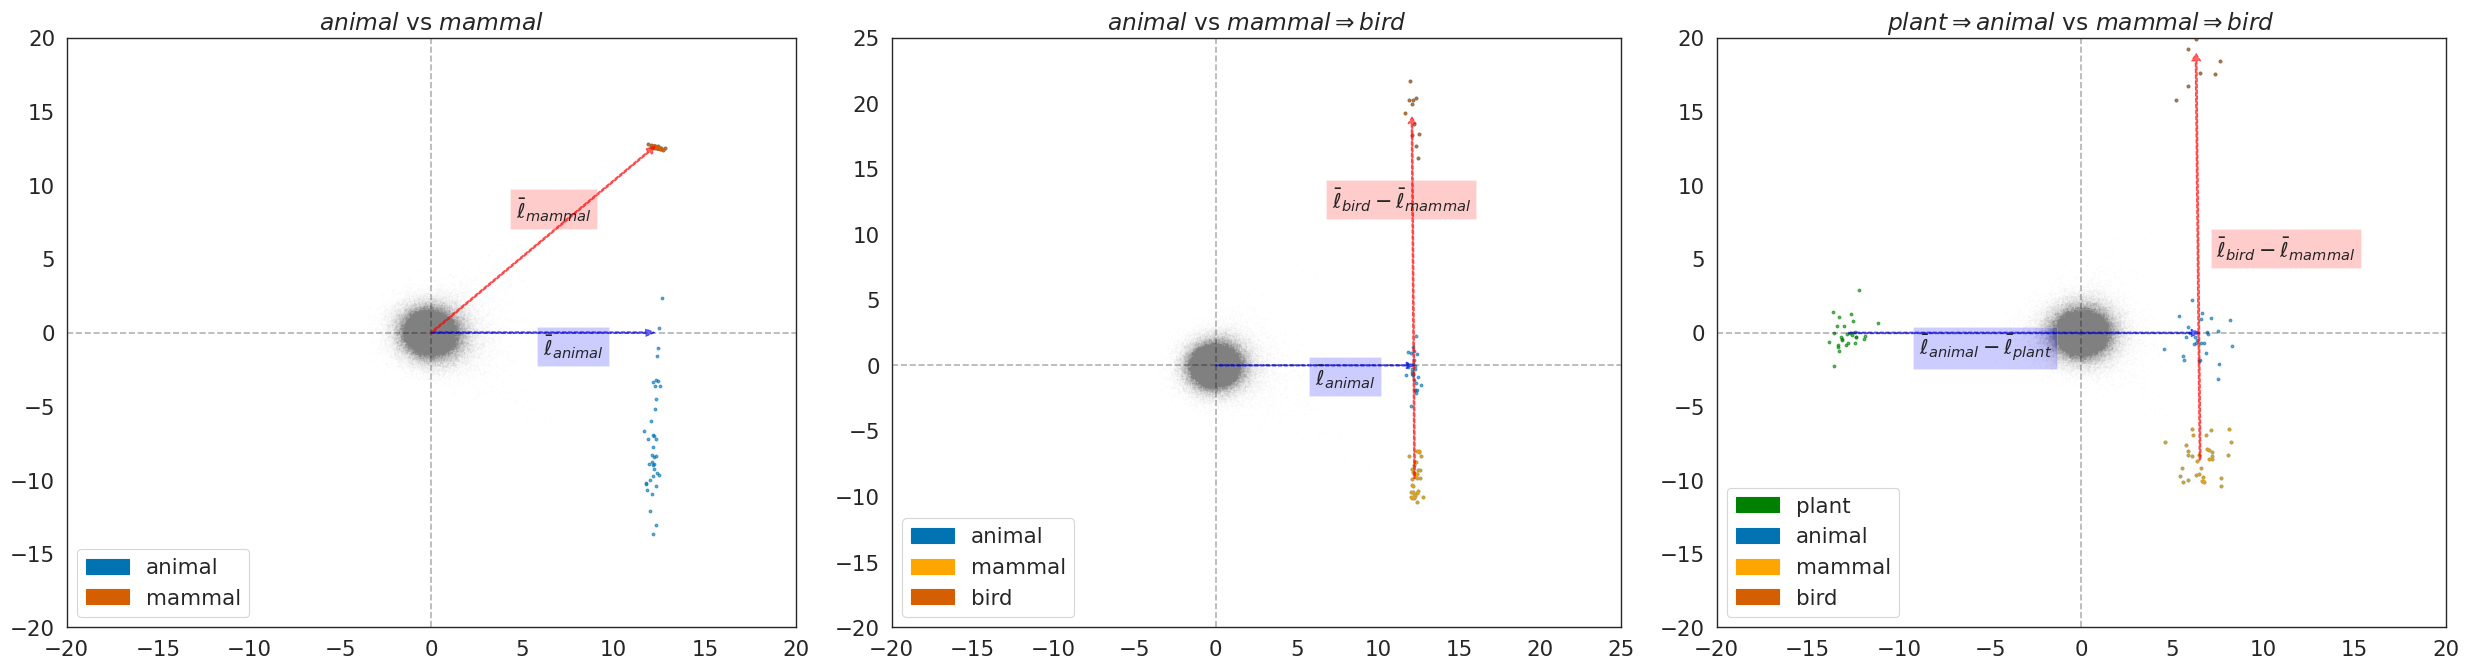

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(25,7))

inds0 = {"animal": hrc.category_to_indices(all_animals_tokens, vocab_dict),
        "mammal": hrc.category_to_indices(animals_token["mammal"], vocab_dict)}
dir1 = dirs["animal"]["lda"]
dir2 = dirs["mammal"]["lda"]
hrc.proj_2d(dir1, dir2, g, vocab_list, axs[0],
            normalize=True,
            orthogonal=True,
            added_inds=inds0, k=200, fontsize=15,
            draw_arrows=True,
            arrow1_name=rf'$\bar{{\ell}}_{{animal}}$',
            arrow2_name=rf'$\bar{{\ell}}_{{mammal}}$',
            alpha = 0.03,  s = 0.05,
            target_alpha=0.6, target_s=4,
            xlim=(-20, 20), ylim=(-20, 20),
            left_topk = False, bottom_topk = False,
            right_topk = False, top_topk = False,
            xlabel = "", ylabel="",
            title=rf'$animal$ vs $mammal$')

inds1 = {"animal": hrc.category_to_indices(all_animals_tokens, vocab_dict),
        "mammal": hrc.category_to_indices(animals_token["mammal"], vocab_dict),
        "bird": hrc.category_to_indices(animals_token["bird"], vocab_dict)}

higher = dirs["animal"]["lda"]
subcat1 = dirs["mammal"]["lda"]
subcat2 = dirs["bird"]["lda"]

hrc.proj_2d_single_diff(higher, subcat1, subcat2,
                        g, vocab_list, axs[1],
                        normalize = True,
                        orthogonal = True,
                        added_inds=inds1, k = 50, fontsize= 15,
                        draw_arrows= True,
                        arrow1_name=rf'$\bar{{\ell}}_{{animal}}$',
                        arrow2_name=rf'$\bar{{\ell}}_{{bird}} - \bar{{\ell}}_{{mammal}}$',
                        alpha = 0.03,  s = 0.05,
                        target_alpha=0.6, target_s=4,
                        xlim = (-20,25), ylim = (-20,25),
                        right_topk = False,
                        left_topk = False,
                        top_topk = False,
                        bottom_topk = False,
                        xlabel = "", ylabel="",
                        title = rf'$animal$ vs $mammal \Rightarrow bird$')

inds2 = {"plant": hrc.category_to_indices(plants_token, vocab_dict),
        "animal": hrc.category_to_indices(all_animals_tokens, vocab_dict),
        "mammal": hrc.category_to_indices(animals_token["mammal"], vocab_dict),
        "bird": hrc.category_to_indices(animals_token["bird"], vocab_dict)}

higher1 = dirs_plants["lda"]
higher2 = dirs["animal"]["lda"]
subcat1 = dirs["mammal"]["lda"]
subcat2 = dirs["bird"]["lda"]

hrc.proj_2d_double_diff(higher1, higher2, subcat1, subcat2,
                        g, vocab_list, axs[2],
                        normalize = True,
                        orthogonal = True,
                        added_inds=inds2, k = 50, fontsize= 15,
                        draw_arrows= True,
                        arrow1_name=rf'$\bar{{\ell}}_{{animal}} - \bar{{\ell}}_{{plant}}$',
                        arrow2_name=rf'$\bar{{\ell}}_{{bird}} - \bar{{\ell}}_{{mammal}}$',
                        alpha = 0.03,  s = 0.05,
                        target_alpha=0.6, target_s=4,
                        xlim = (-20,20), ylim = (-20,20),
                        right_topk = False,
                        left_topk = False,
                        top_topk = False,
                        bottom_topk = False,
                        xlabel = "", ylabel="",
                        title = rf'$plant \Rightarrow animal$ vs $mammal \Rightarrow bird$')

fig.tight_layout()
fig.savefig(f"figures/three_2d_plots.png", dpi=300, bbox_inches='tight')
fig.show()

## 3D Plots

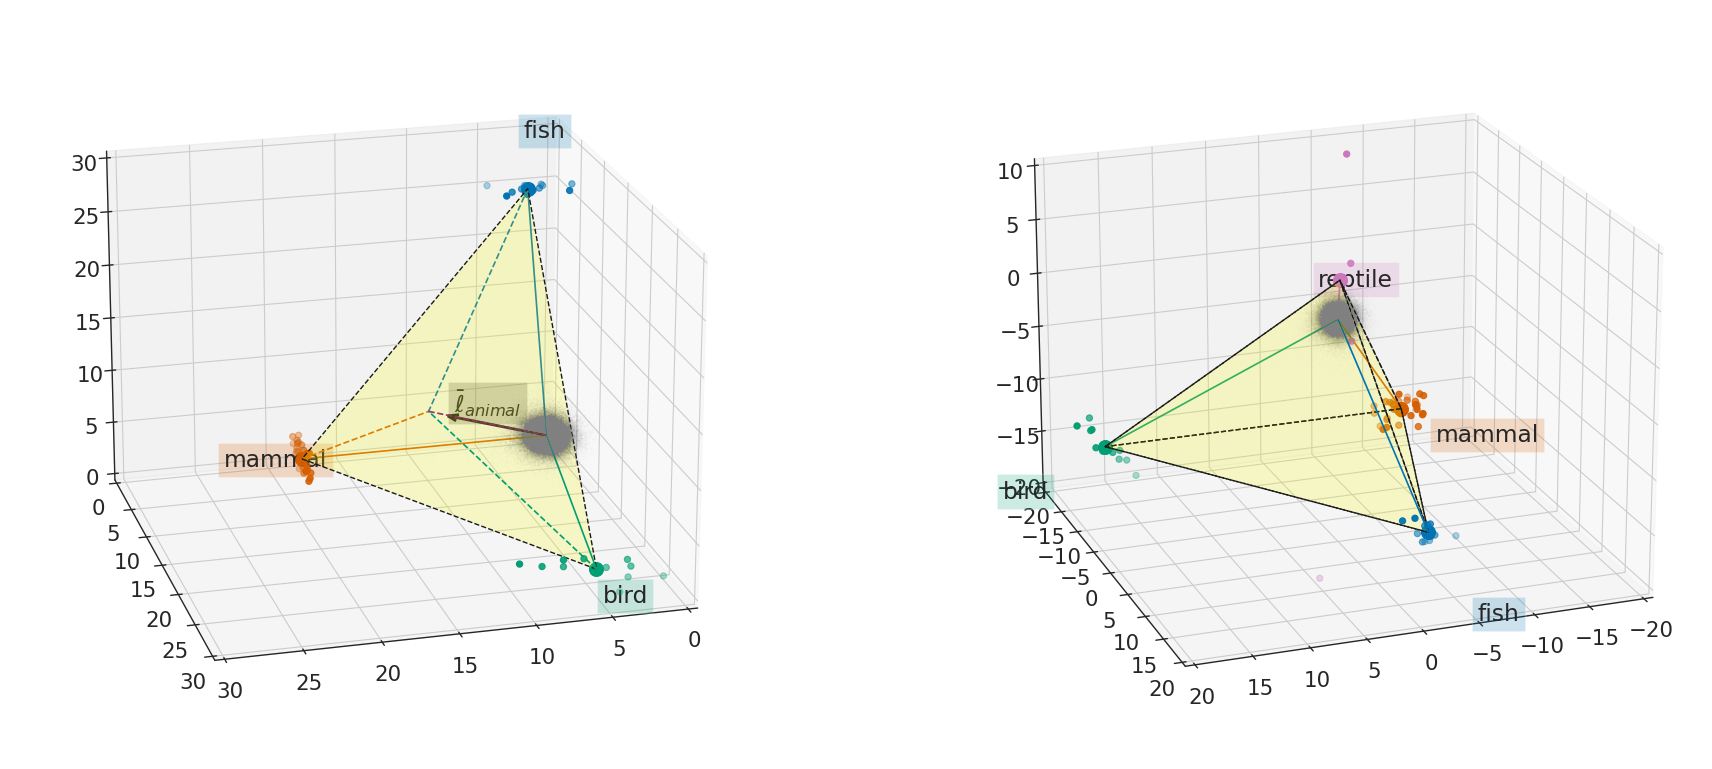

In [6]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121, projection='3d')

cat1 = "mammal"
cat2 = "bird"
cat3 = "fish"

dir1 = dirs[cat1]["lda"]
dir2 = dirs[cat2]["lda"]
dir3 = dirs[cat3]["lda"]
higher_dir = dirs["animal"]["lda"]

xaxis = dir1 / dir1.norm()
yaxis = dir2 - (dir2 @ xaxis) * xaxis
yaxis = yaxis / yaxis.norm()
zaxis = dir3 - (dir3 @ xaxis) * xaxis - (dir3 @ yaxis) * yaxis
zaxis = zaxis / zaxis.norm()

axes = torch.stack([xaxis, yaxis, zaxis], dim=1)

ind1 = hrc.category_to_indices(animals_token["mammal"], vocab_dict)
ind2 = hrc.category_to_indices(animals_token["bird"], vocab_dict)
ind3 = hrc.category_to_indices(animals_token["fish"], vocab_dict)

g1 = g[ind1]
g2 = g[ind2]
g3 = g[ind3]

proj1 = (g1 @ axes).cpu().numpy()
proj2 = (g2 @ axes).cpu().numpy()
proj3 = (g3 @ axes).cpu().numpy()
proj = (g @ axes).cpu().numpy()

P1 = (dir1 @ axes).cpu().numpy()
P2 = (dir2 @ axes).cpu().numpy()
P3 = (dir3 @ axes).cpu().numpy()
P4 = (higher_dir @ axes).cpu().numpy()

ax.scatter(P1[0], P1[1], P1[2], color='r', s=100)
ax.scatter(P2[0], P2[1], P2[2], color='g', s=100)
ax.scatter(P3[0], P3[1], P3[2], color='b', s=100)

verts = [list(zip([P1[0], P2[0], P3[0]], [P1[1], P2[1], P3[1]], [P1[2], P2[2], P3[2]]))]
triangle = Poly3DCollection(verts, alpha=.2, linewidths=1, linestyle =  "--", edgecolors='k')
triangle.set_facecolor('yellow')
ax.add_collection3d(triangle)

ax.quiver(0, 0, 0, P1[0], P1[1], P1[2], color='r', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P2[0], P2[1], P2[2], color='g', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P3[0], P3[1], P3[2], color='b', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P4[0], P4[1], P4[2], color='k', arrow_length_ratio=0.1, linewidth=2)


scatter1 = ax.scatter(proj1[:,0], proj1[:,1], proj1[:,2], c='r', label=cat1)
scatter2 = ax.scatter(proj2[:,0], proj2[:,1], proj2[:,2], c='g', label=cat2)
scatter3 = ax.scatter(proj3[:,0], proj3[:,1], proj3[:,2], c='b', label=cat3)
scatter = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c='gray', s= 0.05, alpha = 0.03)

scale = 1.2
ax.text(P1[0]*scale + 2, P1[1]* scale, P1[2]*scale, cat1, bbox=dict(facecolor='r', alpha=0.2))
ax.text(P2[0]*scale+0.5, P2[1]* scale+0.5, P2[2]*scale, cat2, bbox=dict(facecolor='g', alpha=0.2))
ax.text(P3[0]*scale, P3[1]* scale, P3[2]*scale, cat3, bbox=dict(facecolor='b', alpha=0.2))
ax.text(P4[0]-0.6, P4[1]-0.6, P4[2], rf'$\bar{{\ell}}_{{animal}}$', bbox=dict(facecolor='k', alpha=0.2))

normal_vector = np.cross(P2 - P1, P3 - P1)
normal_vector = normal_vector / np.linalg.norm(normal_vector)
normal_mag = P1 @ normal_vector
normal_vector = normal_vector * normal_mag

P1_normal = P1 - normal_vector
P2_normal = P2 - normal_vector
P3_normal = P3 - normal_vector

ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P1_normal[0], P1_normal[1], P1_normal[2],
          color='r', linestyle =  "--", arrow_length_ratio=0.01)
ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P2_normal[0], P2_normal[1], P2_normal[2],
          color='g', linestyle =  "--", arrow_length_ratio=0.01)
ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P3_normal[0], P3_normal[1], P3_normal[2],
          color='b', linestyle =  "--", arrow_length_ratio=0.01)

ax.quiver(0, 0, 0, normal_vector[0], normal_vector[1], normal_vector[2], color='purple',
          linestyle =  "--", arrow_length_ratio=0.01)


ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.set_zlim(0, 30)

ax.view_init(elev=20, azim=75)




### Second Plot
ax = fig.add_subplot(122, projection='3d')
cat1 = "mammal"
cat2 = "bird"
cat3 = "fish"
cat4 = "reptile"

dir1 = dirs[cat1]["lda"]
dir2 = dirs[cat2]["lda"]
dir3 = dirs[cat3]["lda"]
dir4 = dirs[cat4]["lda"]

xaxis = (dir2 - dir1) / (dir2-dir1).norm()
yaxis = dir3 - dir1 - (dir3-dir1) @ xaxis * xaxis
yaxis = yaxis / yaxis.norm()
zaxis = (dir4 - dir1) - (dir4 - dir1) @ xaxis * xaxis - (dir4 - dir1) @ yaxis * yaxis
zaxis = zaxis / zaxis.norm()

axes = torch.stack([xaxis, yaxis, zaxis], dim=1)

ind1 = hrc.category_to_indices(animals_token["mammal"], vocab_dict)
ind2 = hrc.category_to_indices(animals_token["bird"], vocab_dict)
ind3 = hrc.category_to_indices(animals_token["fish"], vocab_dict)
ind4 = hrc.category_to_indices(animals_token["reptile"], vocab_dict)

g1 = g[ind1]
g2 = g[ind2]
g3 = g[ind3]
g4 = g[ind4]

proj1 = (g1 @ axes).cpu().numpy()
proj2 = (g2 @ axes).cpu().numpy()
proj3 = (g3 @ axes).cpu().numpy()
proj4 = (g4 @ axes).cpu().numpy()
proj = (g @ axes).cpu().numpy()

P1 = (dir1 @ axes).cpu().numpy()
P2 = (dir2 @ axes).cpu().numpy()
P3 = (dir3 @ axes).cpu().numpy()
P4 = (dir4 @ axes).cpu().numpy()

ax.scatter(P1[0], P1[1], P1[2], color='r', s=100)
ax.scatter(P2[0], P2[1], P2[2], color='g', s=100)
ax.scatter(P3[0], P3[1], P3[2], color='b', s=100)
ax.scatter(P4[0], P4[1], P4[2], color='m', s=100)

verts1 = [list(zip([P1[0], P2[0], P3[0]], [P1[1], P2[1], P3[1]], [P1[2], P2[2], P3[2]]))]
triangle1 = Poly3DCollection(verts1, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle1.set_facecolor('yellow')
ax.add_collection3d(triangle1)

verts2 = [list(zip([P1[0], P2[0], P4[0]], [P1[1], P2[1], P4[1]], [P1[2], P2[2], P4[2]]))]
triangle2 = Poly3DCollection(verts2, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle2.set_facecolor('yellow')
ax.add_collection3d(triangle2)

verts3 = [list(zip([P1[0], P3[0], P4[0]], [P1[1], P3[1], P4[1]], [P1[2], P3[2], P4[2]]))]
triangle3 = Poly3DCollection(verts3, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle3.set_facecolor('yellow')
ax.add_collection3d(triangle3)

verts4 = [list(zip([P2[0], P3[0], P4[0]], [P2[1], P3[1], P4[1]], [P2[2], P3[2], P4[2]]))]
triangle4 = Poly3DCollection(verts4, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle4.set_facecolor('yellow')
ax.add_collection3d(triangle4)


ax.quiver(0, 0, 0, P1[0], P1[1], P1[2], color='r', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P2[0], P2[1], P2[2], color='g', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P3[0], P3[1], P3[2], color='b', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P4[0], P4[1], P4[2], color='m', arrow_length_ratio=0.01)


scatter1 = ax.scatter(proj1[:,0], proj1[:,1], proj1[:,2], c='r', label=cat1)
scatter2 = ax.scatter(proj2[:,0], proj2[:,1], proj2[:,2], c='g', label=cat2)
scatter3 = ax.scatter(proj3[:,0], proj3[:,1], proj3[:,2], c='b', label=cat3)
scatter4 = ax.scatter(proj4[:,0], proj4[:,1], proj4[:,2], c='m', label=cat4)
scatter = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c='gray', s= 0.05, alpha = 0.01)


scale = 1.4
scale2 = 1.2
ax.text(P1[0]*scale-1, P1[1]* scale, P1[2]*scale, cat1, bbox=dict(facecolor='r', alpha=0.2))
ax.text(P2[0]*scale+1, P2[1]* scale, P2[2]*scale, cat2, bbox=dict(facecolor='g', alpha=0.2))
ax.text(P3[0]*scale-1, P3[1]* scale, P3[2]*scale, cat3, bbox=dict(facecolor='b', alpha=0.2))
ax.text(P4[0]*scale2+2, P4[1]* scale2, P4[2]*scale2-1, cat4, bbox=dict(facecolor='m', alpha=0.2))

ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_zlim(-20, 10)

ax.view_init(elev=20, azim=70)

plt.tight_layout()
fig.savefig(f"figures/two_3D_plots.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
g.shape

torch.Size([256000, 2048])